In [1]:
from src.config import CACHE_DIR, PERSISTENT_DIR
from src.custom_embeddings import bge_m3_embed, qwen2_embed, nomic_embed
from src.vectorstorage import EmbeddingVectorStorage

print(f"Cache directory: {CACHE_DIR}")

Cache directory: /Users/arian/Documents/FHNW/npr/npr_hs_24/npr_mc1_new_hs24/npr-mc1-frfr/data/cache


In [2]:
# collection names:
# BAAI_bge_m3_RecursiveCharacterTextSplitter
# Alibaba-NLP_gte-Qwen2-7B_RecursiveCharacterTextSplitter
# nomic-ai_nomic-embed-text-v1_5_RecursiveCharacterTextSplitter

# BGE_M3 Embedding Model

In [3]:
# Reload the vector store
bge_m3_vectordb = EmbeddingVectorStorage(
    method_of_embedding=bge_m3_embed,
    collection='BAAI_bge_m3_RecursiveCharacterTextSplitter',
    path_persistent=str(PERSISTENT_DIR)
)

qwen2_vectordb = EmbeddingVectorStorage(
    method_of_embedding=qwen2_embed,
    collection="Alibaba-NLP_gte-Qwen2-7B_RecursiveCharacterTextSplitter",
    path_persistent=str(PERSISTENT_DIR)
)

nomic_vectordb = EmbeddingVectorStorage(
    method_of_embedding=nomic_embed,
    collection="nomic-ai_nomic-embed-text-v1_5_RecursiveCharacterTextSplitter",
    path_persistent=str(PERSISTENT_DIR)
)

print(f"bge_m3 Heartbeat: {bge_m3_vectordb.test_heartbeat()}, bge_m3 Collection is empty: {bge_m3_vectordb.collection_is_empty()}")
print(f"qwen2 Heartbeat: {qwen2_vectordb.test_heartbeat()}, qwen2 Collection is empty: {qwen2_vectordb.collection_is_empty()}")
print(f"nomic Heartbeat: {nomic_vectordb.test_heartbeat()}, nomic Collection is empty: {nomic_vectordb.collection_is_empty()}")

bge_m3 Heartbeat: 1732152321208399000, bge_m3 Collection is empty: False
qwen2 Heartbeat: 1732152321309231000, qwen2 Collection is empty: False
nomic Heartbeat: 1732152321406081000, nomic Collection is empty: False


In [4]:
from langchain_ollama import OllamaLLM
from langchain_openai import ChatOpenAI
from src.evaluation import RAGEvaluation
from dotenv import load_dotenv

load_dotenv()

qwen2_5_3B = 'qwen2.5:3b-instruct-q4_0'
qwen2_5_7B = 'qwen2.5:7b-instruct-q4_0'
qwen2_5_14B = 'qwen2.5:14b-instruct-q4_0'
qwen2_5_32B = 'qwen2.5:32b-instruct-q4_0'
llama_3_2_3B = 'llama3.2:3b-instruct-q4_0'
mistral_7b = 'mistral:7b-instruct-v0.3-q4_0'
gemma_7b = 'gemma:7b-instruct-q4_0'

basic_retriever = bge_m3_vectordb.as_retriever()
local_llm_model = OllamaLLM(model=qwen2_5_3B)

# Initialize the class
openai_llm_model = ChatOpenAI(model="gpt-4o-mini")

In [5]:
from langchain import hub
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough, RunnableParallel

# https://python.langchain.com/v0.1/docs/use_cases/question_answering/sources/
# prompt: https://smith.langchain.com/hub/rlm/rag-prompt?organizationId=2d6cd9b7-5b49-44db-a523-a13c23f12f29
basic_prompt = hub.pull("rlm/rag-prompt")


def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

rag_chain_from_docs = (
    RunnablePassthrough.assign(context=(lambda x: format_docs(x["context"])))
    | basic_prompt
    | local_llm_model
    | StrOutputParser()
)

basic_rag_chain = RunnableParallel(
    {"context": basic_retriever, "question": RunnablePassthrough()}
).assign(answer=rag_chain_from_docs)

result = basic_rag_chain.invoke("The company is also aiming to reduce gas flaring?")

In [6]:
result['context']

[Document(metadata={'date': '2021-12-13', 'domain': 'naturalgasintel', 'origin_doc_id': '955ad75cdc5396c0057252d76df2c445', 'title': 'ExxonMobil Envisions Carbon-Neutral Permian Operations by 2030', 'url': 'https://www.naturalgasintel.com/exxonmobil-envisions-carbon-neutral-permian-operations-by-2030/'}, page_content='their natural gas prices off of NGI s Mexico Gas Price Index. Read the analysis of our fifth survey of active players in Mexico, showcasing market driven insights now. , The company plans to electrify its operations with low carbon power, which may include wind, solar, hydrogen, natural gas with carbon capture and storage, or other emerging technologies, the firm said. ExxonMobil plans to expand its methane detection programs utilizing satellite surveillance and a network of ground based sensors for continuous monitoring, and aerial flyovers that identify leaks for rapid repairs. , By the end of this year, ExxonMobil plans to reduce flaring volumes across its Permian oper

In [7]:
from src.config import CLEAN_FILE_PATH, EVAL_FILE_PATH

evaluator = RAGEvaluation(
    name="Baseline_BGE_m3",
    rag_chain=basic_rag_chain,
    llm_model=openai_llm_model,
    local_llm=local_llm_model.model,
    embeddings=bge_m3_embed
)

clean_file_path=str(CLEAN_FILE_PATH)
eval_file_path=str(EVAL_FILE_PATH)

# Perform evaluation
results = evaluator.evaluate(clean_file_path, eval_file_path, bge_m3_vectordb)

Loading cached data from: /Users/arian/Documents/FHNW/npr/npr_hs_24/npr_mc1_new_hs24/npr-mc1-frfr/data/cache/Baseline_BGE_m3_qwen2.5:3b-instruct-q4_0_BAAI_bge_m3_gpt-4o-mini_eval_result.pkl


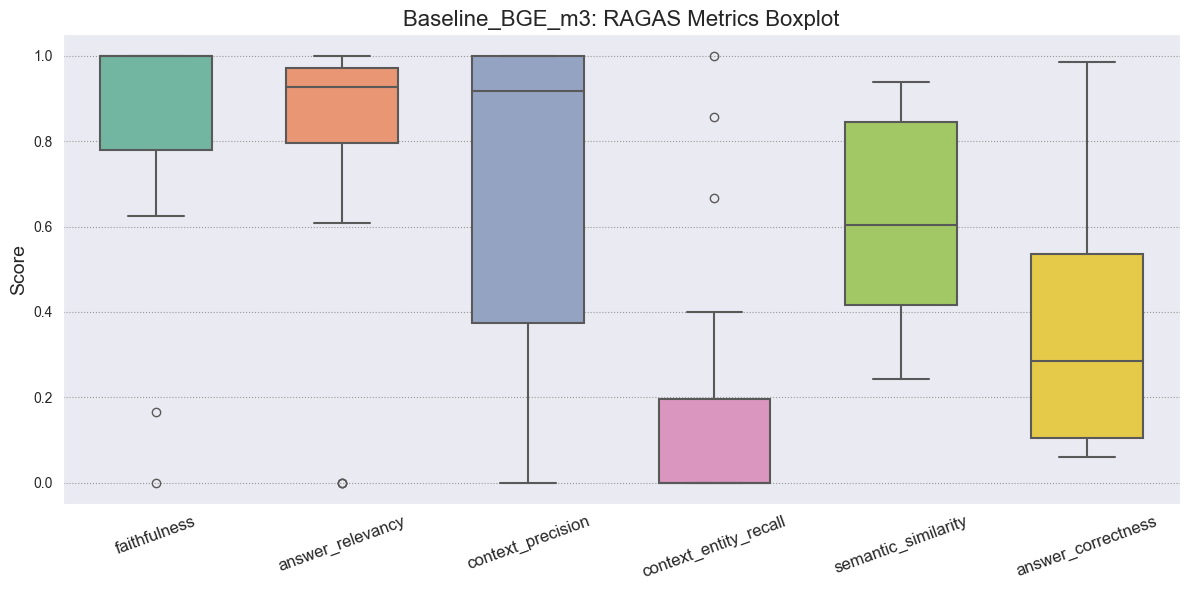

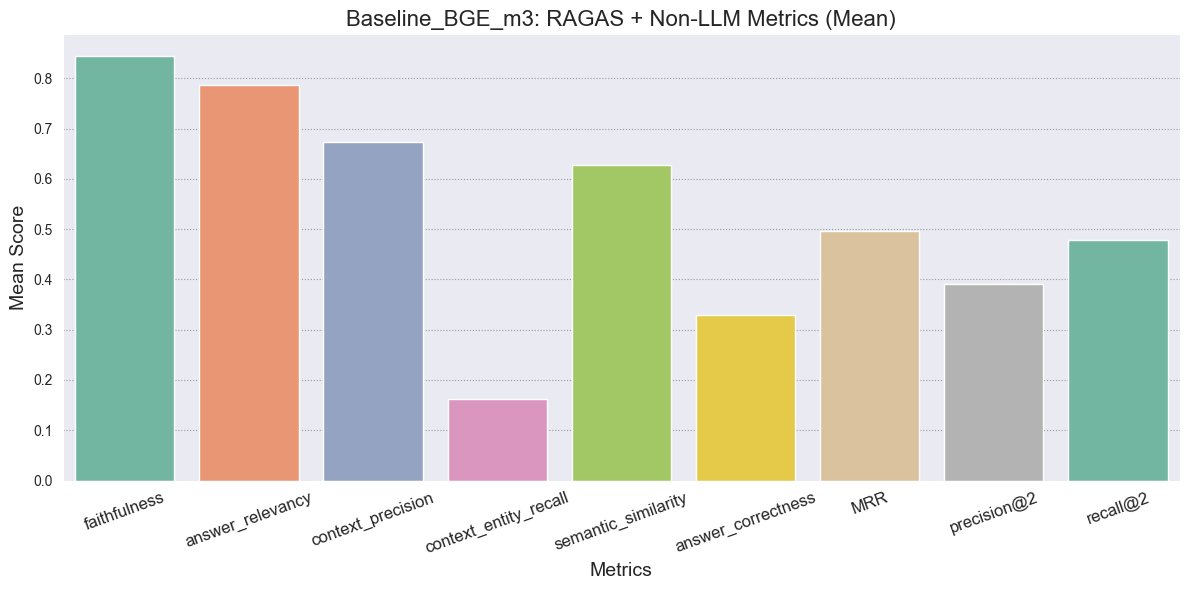

In [8]:
evaluator.plot_results_all(results, results)